# ANN: ChestXRay

## Problem Statement:

The provided text offers a description of a dataset that consists of chest X-ray images used for pneumonia diagnosis. Below is a content summary overview of the problem and dataset:

### About the Dataset:

1. **Purpose**: The dataset is meant to support the diagnosis of pneumonia, an infection that significantly affects the lungs and is a leading cause of death among children under 5 years old.
2. **Composition**: It contains 5,856 chest X-ray images that have been validated for quality and accuracy.
3. **Structure**: The images are divided into two sets: a training set and a testing set, which feature images from independent patients to ensure the reliability of testing.
4. **Labeling**: Each image in the dataset is labeled with the type of disease (Normal, Bacteria, or Virus), a randomized patient ID, and a number indicating the sequence of images for that patient.
5. **Data Source**: The images were collected from pediatric patients aged one to five at the Guangzhou Women and Children’s Medical Center in Guangzhou.

### Context:

- **Clinical Relevance**: Pneumonia is diagnosed based on symptoms and physical examinations, and chest X-rays are a critical part of confirming the diagnosis.

### Inspiration:

- The dataset can be utilized for developing, training, and testing classification models, particularly those based on convolutional neural networks (CNNs), which are highly effective for image recognition tasks.

### Acknowledgements and References:
- The dataset is sourced from a publicly available repository on Mendeley and is licensed under CC BY 4.0.
- The reference provided is a paper that likely contains details on the data collection process and a description of the dataset.

### TASK:
We will be creating a Convolutional Neural Network (CNN) to analyze a dataset of chest X-ray images for pneumonia diagnosis, a critical health issue in children under five. The dataset is neatly split into training and testing sets, with images labeled as normal or viral pneumonia. Our CNN will learn to identify these conditions through feature recognition and pattern analysis. After training, we'll assess the model's accuracy on unseen data to ensure it can support medical professionals in making swift, precise diagnoses. This project aims to harness deep learning to enhance the diagnostic process and improve patient outcomes.

Source:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## 0.Importing Libraries:

In [1]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import joblib
import pickle

##1. Load the Datasets:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define paths for the dataset (update these paths based on your setup)
train_dir = '/content/drive/Shareddrives/MBD Term2 - Group 6/ML_Group Project/chest_xray/train'
test_dir = '/content/drive/Shareddrives/MBD Term2 - Group 6/ML_Group Project/chest_xray/test'

## 1.2: Setting up data generators

In [5]:
# Create ImageDataGenerators for image augmentation and data loading
# Augmenting the images in the train set for the underrepresented class using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
# No augmentation for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Create generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


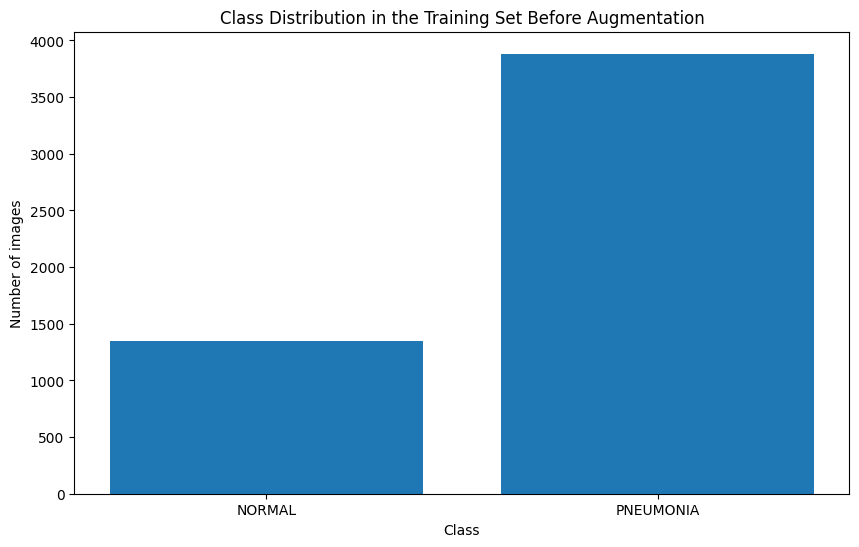

In [7]:
# Class distribution in the training set before augmentation
class_labels = list(train_generator.class_indices.keys())
class_counts = np.unique(train_generator.classes, return_counts=True)[1]
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Training Set Before Augmentation')
plt.show()

In [8]:
# Steps per epoch for balancing the classes
min_class_count = min(class_counts)
desired_epoch_samples = min_class_count * 2  # Assuming binary classification
steps_per_epoch = desired_epoch_samples // train_generator.batch_size

## 2. Visualize data and EDA:

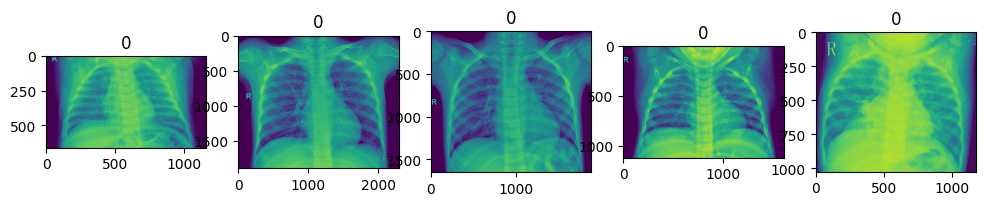

In [9]:
# Display a few sample images from the dataset
sample_images = random.sample(train_generator.filepaths, 5)

plt.figure(figsize=(12, 8))
for i, image_path in enumerate(sample_images):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(train_generator.classes[i])
plt.show()

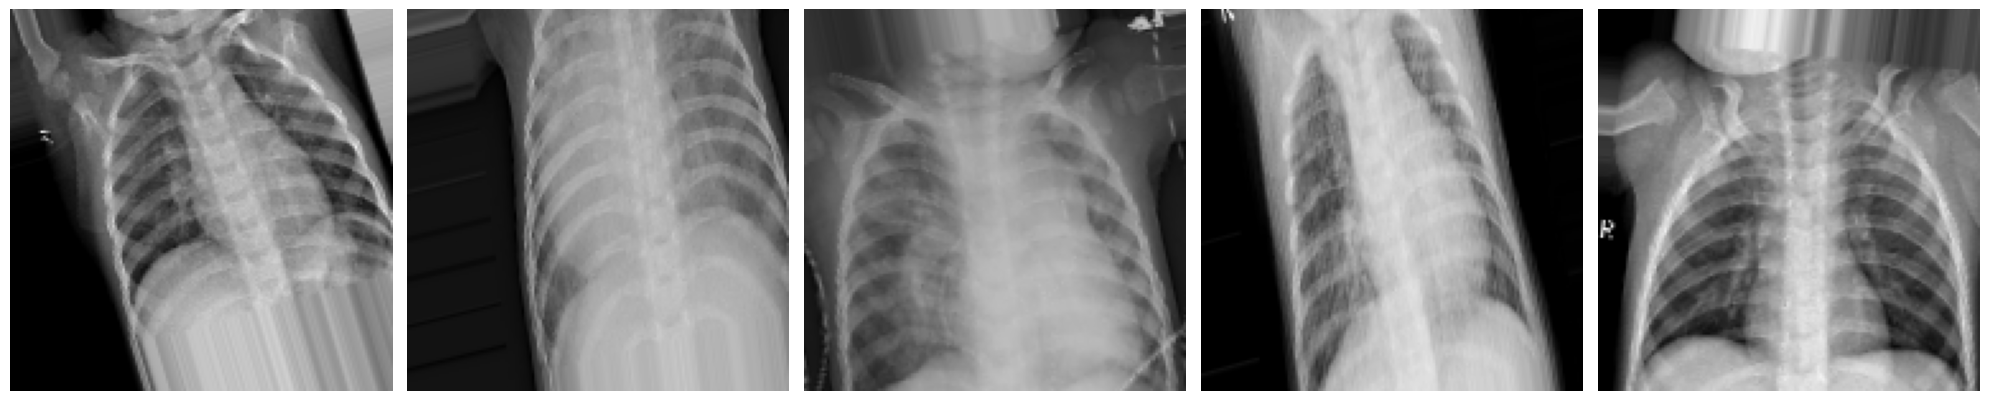

In [10]:
# Visualize some images from the dataset
def plot_images(images_arr, labels):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images from the training generator
images, labels = next(train_generator)
plot_images(images[:5], labels[:5])  # Plot the first 5 images and their labels

In [11]:
# Image statistics
mean = np.mean(images, axis=(0, 1, 2))
std = np.std(images, axis=(0, 1, 2))

print(f"Mean pixel values (RGB): {mean}")
print(f"Stddev pixel values (RGB): {std}")

Mean pixel values (RGB): [0.46821815 0.46821815 0.46821815]
Stddev pixel values (RGB): [0.25220695 0.25220695 0.25220695]


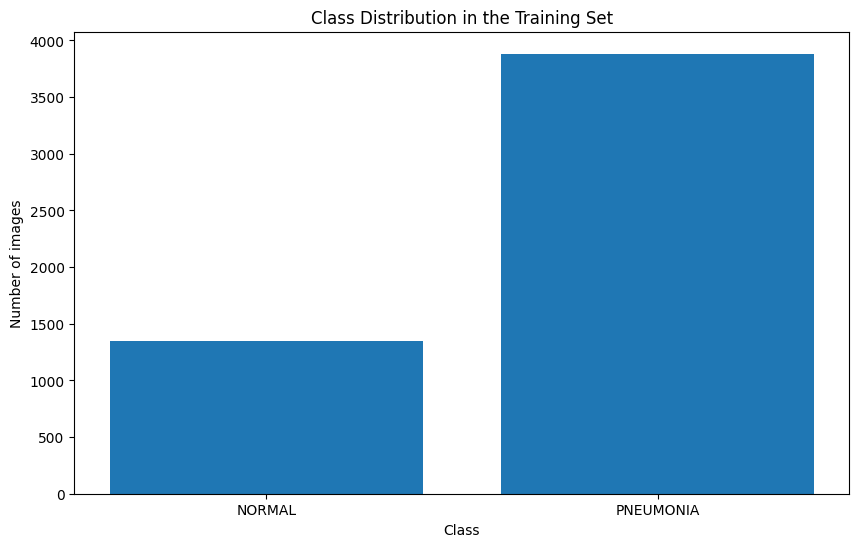

In [12]:
# Class distribution
class_labels = list(train_generator.class_indices.keys())
class_counts = np.unique(train_generator.classes, return_counts=True)[1]

plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Training Set')
plt.show()

As we can see, the dataset is unbalanced. With a majority of the dataset that refers to Pneumonia chest and not healthy ones. It is important to take this into consideration and balance out the dataset.

To do so we will use data augmentation to generate more images for the underrepresented class (normal XRay Chest). With *ImageDataGenerator*, we will increase the number of images for the minority class by creating more augmented images.

In [13]:
# After your train_generator has been defined
class_indices = train_generator.class_indices
class_counts = dict(zip(class_indices, np.bincount(train_generator.classes)))

print("Class distribution before augmentation:")
print(class_counts)


Class distribution before augmentation:
{'NORMAL': 1349, 'PNEUMONIA': 3883}


## 3. Train/Test Split:

4.1:Building the model and Hyperparameter tuning:

In [14]:
# Define a function to build a Keras model with hyperparameters
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Define hyperparameters to tune
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
# Initialize Bayesian optimization
bayesian_tuner = kt.BayesianOptimization(build_model,
                                        objective='val_accuracy',
                                        max_trials=3,
                                        executions_per_trial=1,
                                        directory='mysecond_dir',
                                        project_name='ANN_best_model')

In [16]:
# Train the model with hyperparameter tuning
bayesian_tuner.search(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=test_generator,
                      validation_steps=len(test_generator),
                      epochs=3)

Trial 3 Complete [00h 09m 51s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.8092948794364929
Total elapsed time: 00h 41m 43s


In [17]:
# Get the best hyperparameters
bayesian_tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.0001}

In [18]:
models = bayesian_tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [19]:
bayesian_tuner.results_summary()

Results summary
Results in mysecond_dir/ANN_best_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.8092948794364929

Trial 0 summary
Hyperparameters:
learning_rate: 0.001
Score: 0.7083333134651184

Trial 2 summary
Hyperparameters:
learning_rate: 0.01
Score: 0.625


In [20]:
# Get the best hyperparameters
best_hyperparameters = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hyperparameters.get('learning_rate')
print("Best Learning Rate:", best_learning_rate)

Best Learning Rate: 0.0001


## 4: Prediction & Model Evaluation:

In [21]:
# Make predictions on a test batch using the best model
best_model = bayesian_tuner.get_best_models(num_models=1)[0]

# Predictions on the test set and Convert probabilities to class labels (0 or 1)
predictions = best_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)

20/20 [==============================] - 16s 753ms/step


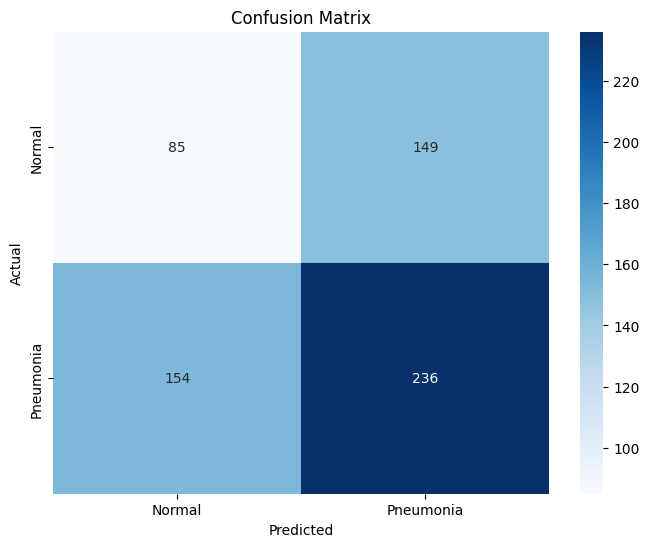

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
true_labels = test_generator.classes
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [26]:
from sklearn.metrics import classification_report

print("Classification Report:")
target_names = ['Normal', 'Pneumonia']
print(classification_report(true_labels, predicted_labels, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.36      0.36      0.36       234
   Pneumonia       0.61      0.61      0.61       390

    accuracy                           0.51       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.52      0.51      0.52       624



The confusion matrix and classification report offer a quantitative evaluation of your CNN's performance on the test data for pneumonia diagnosis.

The confusion matrix show that:
- True Positives (TP) for Normal: 85 (instances correctly predicted as Normal)
- False Negatives (FN) for Normal: 149 (instances of Normal incorrectly predicted as Pneumonia)
- False Positives (FP) for Pneumonia: 154 (instances of Pneumonia incorrectly predicted as Normal)
- True Positives (TP) for Pneumonia: 236 (instances correctly predicted as Pneumonia)

The Classification Report Analysis:
- **Precision** for Normal is 0.36, meaning that when the model predicts Normal, it is correct about 36% of the time.
- **Recall** for Normal is 0.36, indicating that the model correctly identifies 36% of all actual Normal cases.
- **F1-score** for Normal is 0.36, a balance between precision and recall, suggesting that the model is not performing well at distinguishing Normal cases.

For Pneumonia:
- **Precision** is 0.61, so the model's predictions are correct 61% of the time when it predicts Pneumonia.
- **Recall** is 0.61, meaning the model captures 61% of all actual Pneumonia cases.
- **F1-score** is 0.61, suggesting a moderately better performance at identifying Pneumonia cases compared to Normal.

The **accuracy** of the model is 51%, indicating that it correctly predicts Normal and Pneumonia combined over half the time, which is not particularly high.

The **macro average** F1-score is 0.48, and the **weighted average** F1-score is 0.52, which factors in the support (the number of true instances for each label). These scores suggest that the model's performance is at chance level, which isn't adequate for a reliable diagnostic tool.

## 5: Export model:

In [27]:
model = best_model

In [28]:
# Save the model in HDF5 format
model_filename = 'ANN_ChestXRay_model.h5'
model.save(model_filename)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
